In [1]:
import scripts.init_gpu as init_gpu
import scripts.init_dataset as init_dataset
from scripts.train_vae import VAE, Sampling
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

def data_preprocessing(df, location_label, vae: VAE):
    """
    Filter the dataframe by Location, sort by Website, and drop specified columns.
    """

    le = LabelEncoder()
    loc_df = df[df['Location'] == location_label].sort_values(by=[
                                                                'Website'])
    loc_data = loc_df.iloc[:, 2:].to_numpy()
    loc_websites = le.fit_transform(loc_df.Website.to_numpy())

    _, _, loc_latent_embeddings = vae.encode(loc_data)
    return loc_latent_embeddings, loc_websites

n_neurons = 32

init_gpu.initialize_gpus()

locations = ['LOC1', 'LOC2']

print("Loading Dataset...")
# load the dataset
df = pd.read_csv(
    f"../dataset/processed/{locations[0]}-{locations[1]}-scaled-balanced.csv")

length = len(df.columns) - 2  # subtract the two label columns

# get train-test set
train_df, test_df, train_web_samples, test_web_samples = init_dataset.get_sample(
    df, locations, range(1500), 1200)



2024-11-07 09:55:05.138496: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 09:55:05.145527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730933705.153981 2558716 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730933705.156527 2558716 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 09:55:05.165413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  2
Loading Dataset...
Training Websites: [1309, 228, 51, 563, 501, 457, 285, 209, 1385, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 1232, 54, 1149, 407, 1466, 1330, 1436, 1490, 859, 451, 919, 1206, 569, 13, 326, 1429, 865, 696, 1468, 318, 440, 689, 1492, 189, 778, 198, 735, 704, 1236, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 1287, 1266, 740, 1182, 393, 142, 93, 1354, 466, 592, 163, 1482, 206, 1456, 1462, 928, 1301, 747, 333, 758, 727, 429, 1372, 546, 1399, 1327, 146, 1247, 1300, 350, 1093, 1495, 334, 946, 777, 552, 1310, 1140, 449, 1402, 664, 114, 469, 1486, 646, 821, 548, 135, 432, 1161, 644, 435, 1342, 1022, 810, 1316, 939, 292, 542, 1493, 505, 1478, 1103, 538, 1197, 877, 1195, 817, 741, 1404, 283, 1043, 1010, 186, 96, 224, 313, 1285, 327, 1487, 1221, 130, 788, 781, 1220, 958, 1083, 514, 1133, 23, 234, 1099, 1419, 1312, 1463, 1498, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 1280, 611, 1308, 1338, 1415, 1477, 1366, 765, 330, 1104, 1086, 1, 1226, 

/home/asil0892/doh_traffic_analysis/code/scripts/init_dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["Location"], inplace=True)


# load models

In [2]:
from scripts.lsm import BridgingVAE, SharedDecoder, SharedEncoder, Classifier
from scripts.train_vae import VAE, Sampling

# Load VAE models
LOC1_vae = tf.keras.models.load_model(
    "../models/vae/LOC1-e400-mse1-kl0.01.keras")
LOC2_vae = tf.keras.models.load_model(
    "../models/vae/LOC2-e400-mse1-kl0.01.keras")


# Model parameters
input_dim = n_neurons
hidden_dim = 128
latent_dim = n_neurons
num_classes = 1200
batch_size = 128
epochs = 1000

# Initialize the BridgingVAE model
model = BridgingVAE(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)

model.load_weights("../models/vae/bridging_vae_weights-1-0.01-0.01-1.weights.h5")
model.trainable = False

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1730933721.437176 2558716 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1730933721.437268 2558716 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22281 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1730933721.437402 2558716 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 1
I0000 00:00:1730933721.437457 2558716 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22289 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:71:00.0, compute capability: 8.9
/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: Us

# prepare test dataset

In [8]:
def data_preprocessing(df, location_label, vae: VAE):
    """
    Filter the dataframe by Location, sort by Website, and drop specified columns.
    """

    le = LabelEncoder()
    loc_df = df[df['Location'] == location_label].sort_values(by=[
                                                                'Website'])
    loc_data = loc_df.iloc[:, 2:].to_numpy()
    loc_websites = le.fit_transform(loc_df.Website.to_numpy())

    _, _, loc_latent_embeddings = vae.encode(loc_data)
    return loc_latent_embeddings, loc_websites

# get domain specific latent space embeddings
x_LOC1, y_LOC1 = data_preprocessing(test_df, 'LOC1', LOC1_vae)
x_LOC2, y_LOC2 = data_preprocessing(test_df, 'LOC2', LOC2_vae)

one_hot_encoded_loc = {'LOC1': np.array([0.0, 1.0]).astype(
    'float32'), 'LOC2': np.array([1.0, 0.0]).astype('float32')}

# Create domain labels
LOC1_domain_labels = np.tile(one_hot_encoded_loc['LOC1'], (len(x_LOC1), 1))
LOC2_domain_labels = np.tile(one_hot_encoded_loc['LOC2'], (len(x_LOC2), 1))

# Synthesis

In [4]:
# get the LOC1 latent space embeddings, attach the domain label LOC1 to map it to the shared latent space
shared_latent_embeddings_LOC1, _, _ = model.encode(x_LOC1, LOC1_domain_labels)

# decode the shared latent space embeddings to the latent space of the LOC2
synthesized_LOC1_on_LOC2_latent_space = model.decode(shared_latent_embeddings_LOC1, LOC2_domain_labels)

# decode the latent space embeddings from LOC2 to synthesis data
synthesized = LOC2_vae.decode(synthesized_LOC1_on_LOC2_latent_space)

# Test synthesis

In [5]:
from scripts.train_vae import filter_and_sort_data
synth_location = 'LOC2'
X_test = filter_and_sort_data(test_df, synth_location).to_numpy().astype('float32')

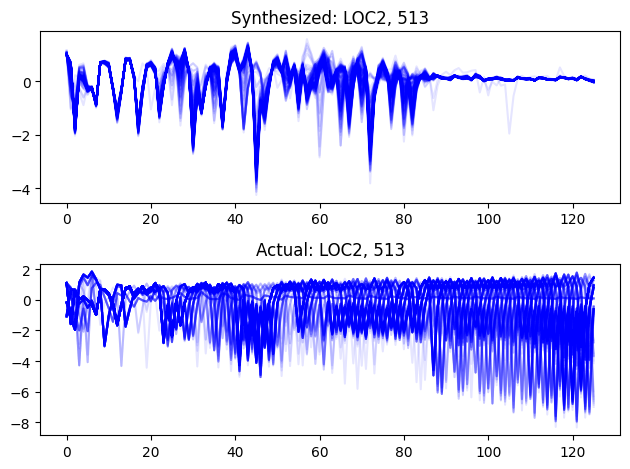

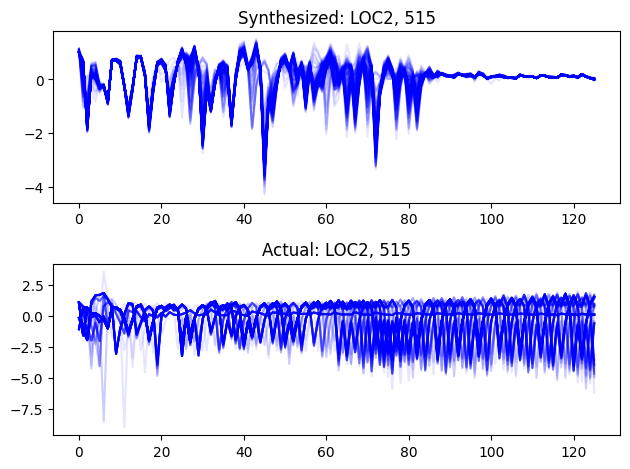

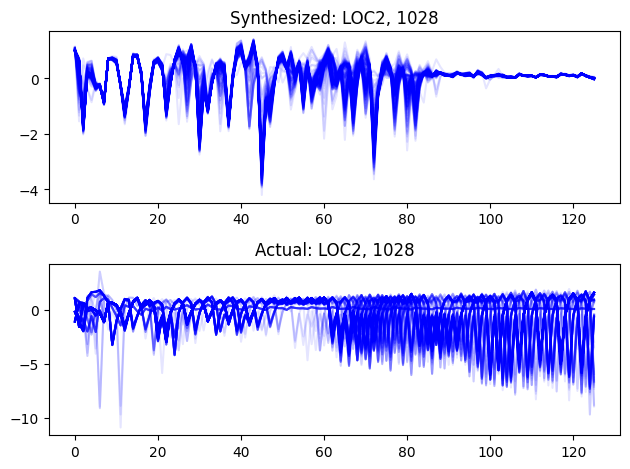

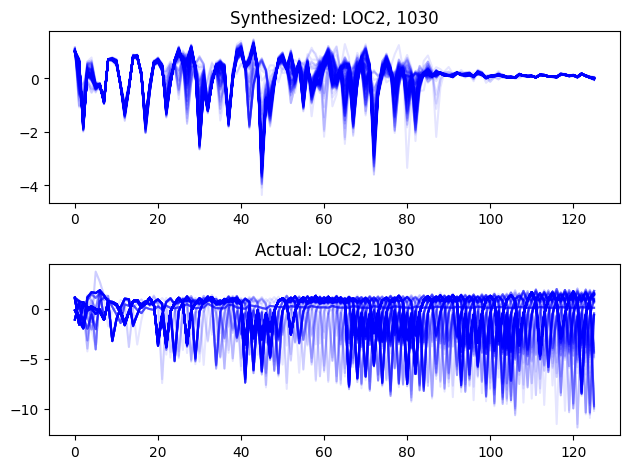

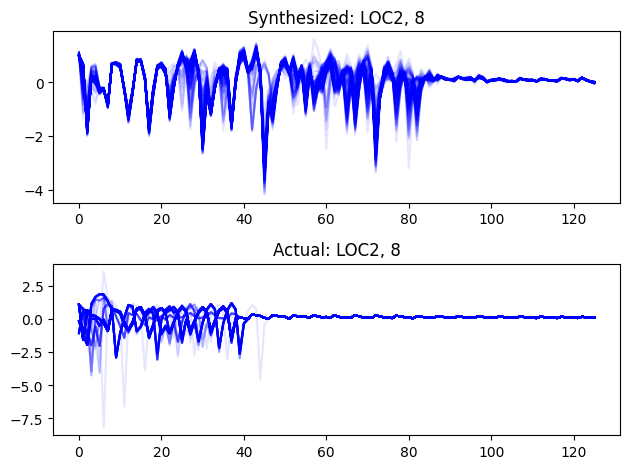

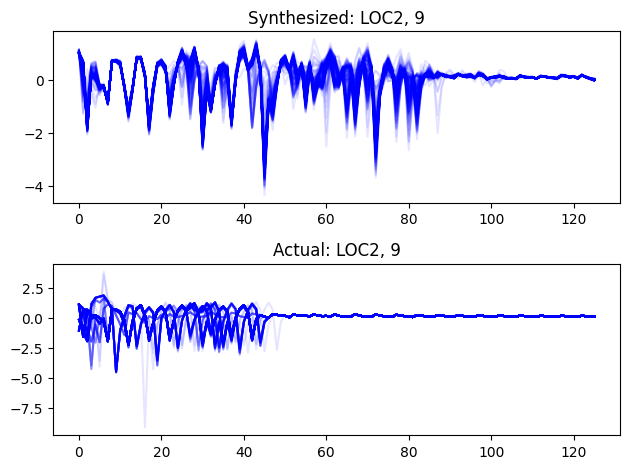

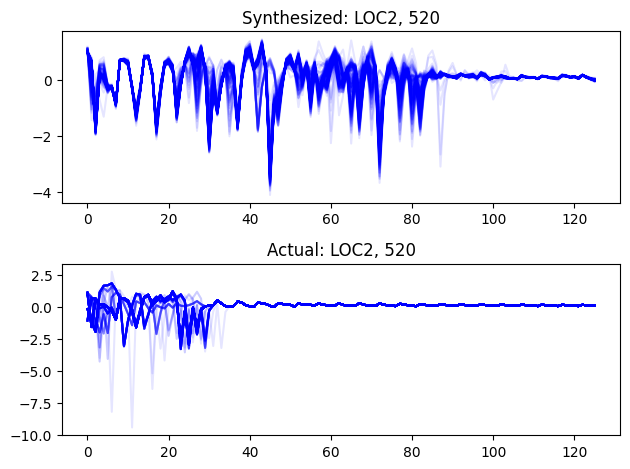

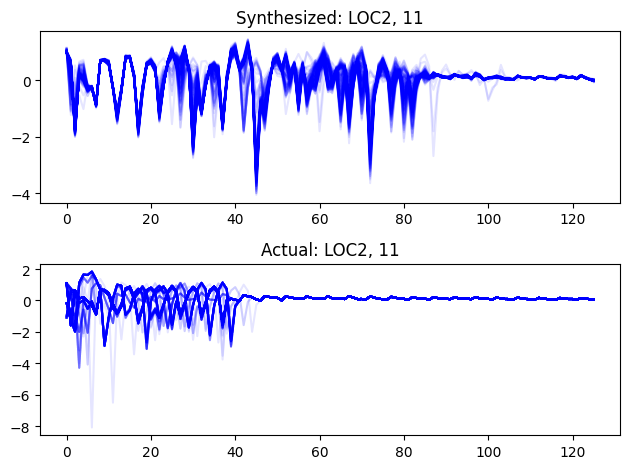

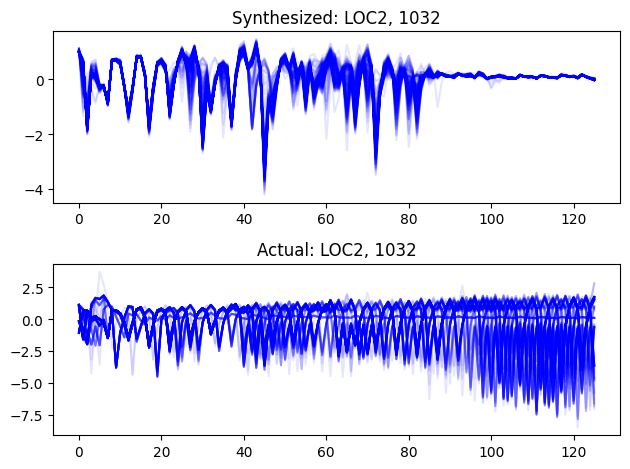

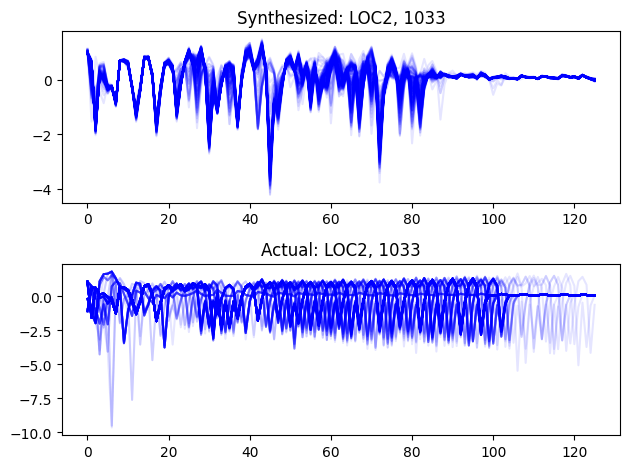

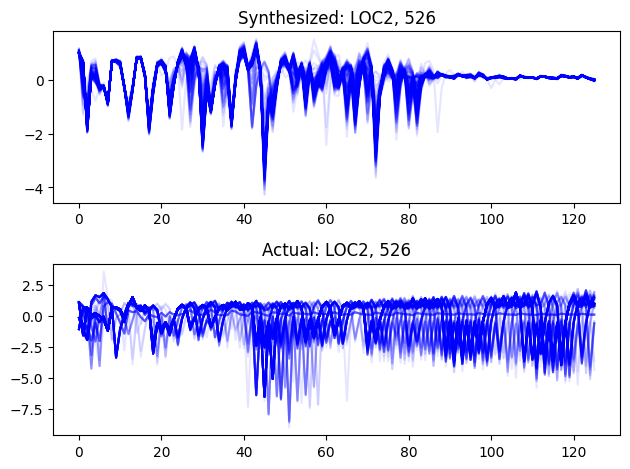

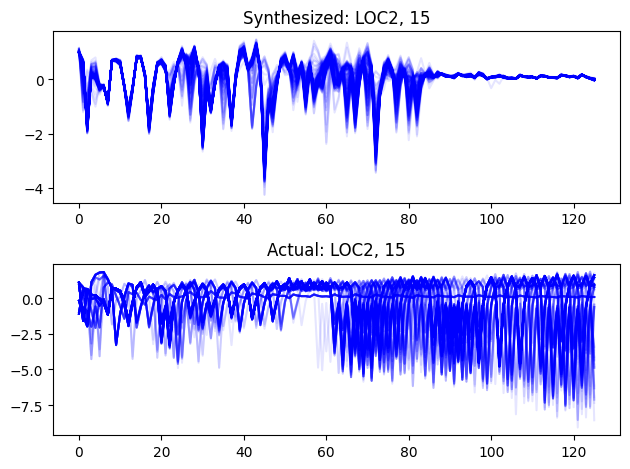

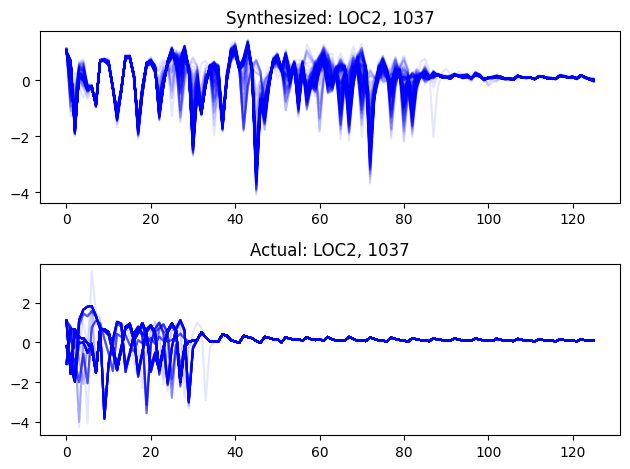

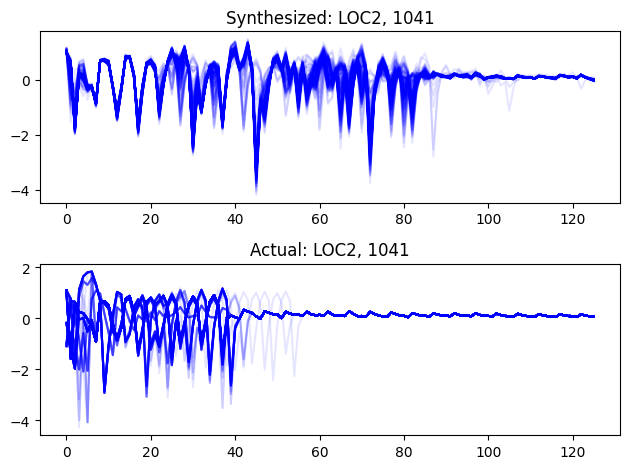

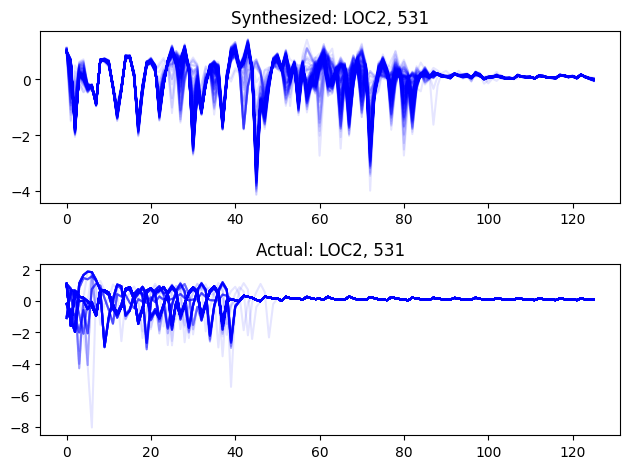

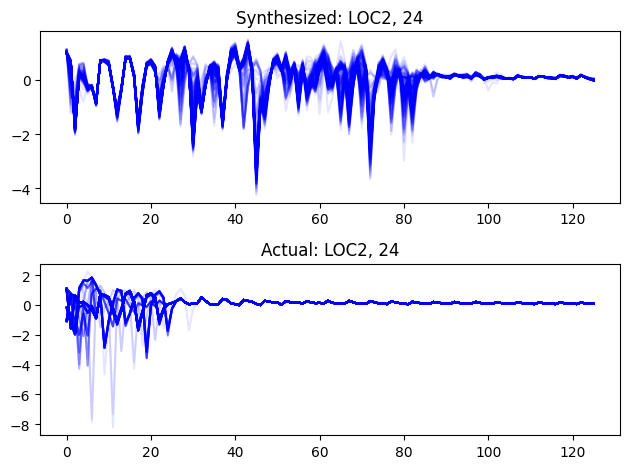

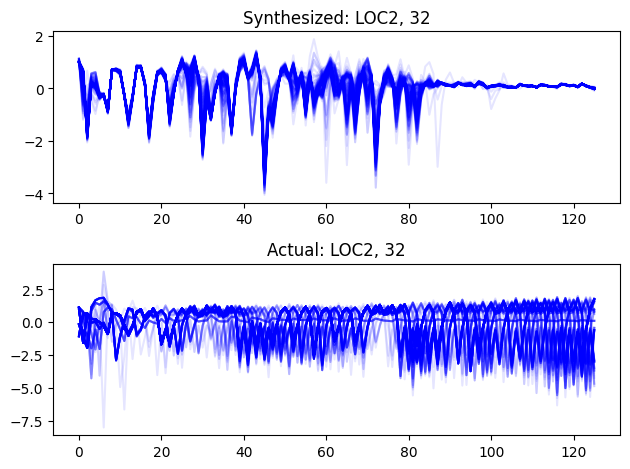

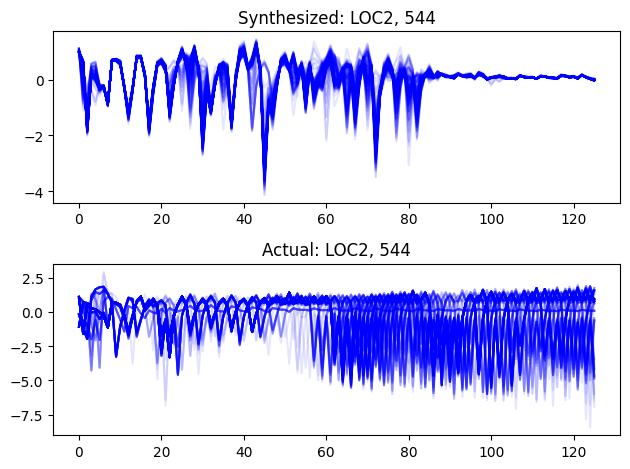

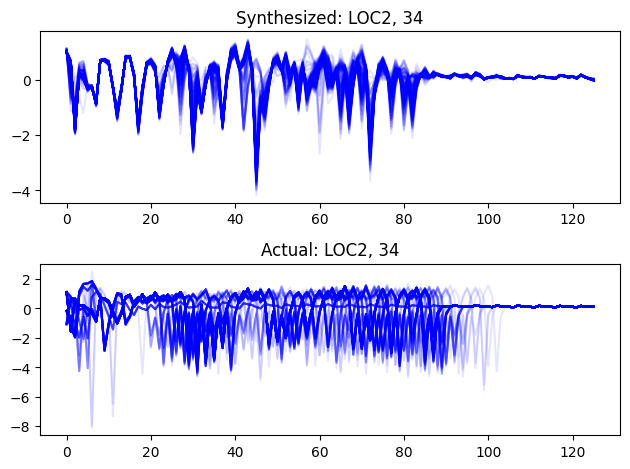

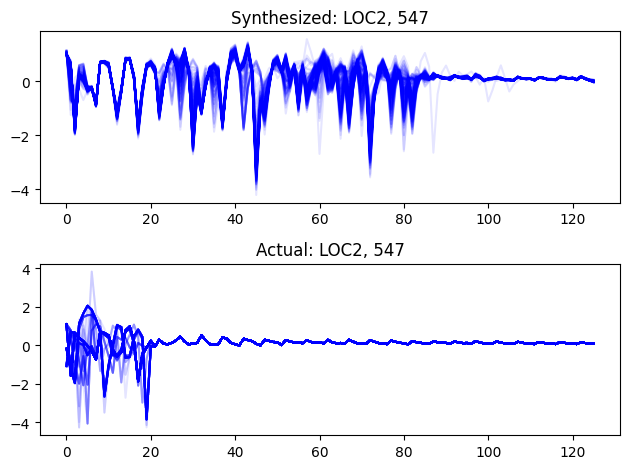

In [7]:
import matplotlib.pyplot as plt

for i in range(0, 200 * 20, 200):

    plt.figure()

    plt.subplot(2, 1, 1)
    traces = synthesized[i:i+200]
    for j in range(200):
        plt.plot(traces[j], alpha=0.1, c='b')
    plt.title(f"Synthesized: {synth_location}, {test_web_samples[i // 200]}")

    plt.subplot(2, 1, 2)
    traces = X_test[i:i+200]
    for j in range(200):
        plt.plot(traces[j], alpha=0.1, c='b')
    plt.title(f"Actual: {synth_location}, {test_web_samples[i // 200]}")

    plt.tight_layout()
    plt.show()
    plt.close()

